In [1]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet
import pyarrow.dataset
import pyarrow.compute as pc

import jobqueue
from jobqueue.connection_manager import ConnectionManager



import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import h5py as h5
import hdf5plugin

pd.options.display.max_seq_items = None

In [71]:

max_epochs = int(1e9)
max_parameters = int(100e9)

with h5.File('/home/ctripp/test/ff8dbc21-2c7e-4d7a-b0a3-283abc251f1c.h5', 'r') as src:
    with h5.File('/home/ctripp/test/512x64_lz4_5.h5', 'w') as dst:
        src_dataset = src["parameter"]

        print(src_dataset.shape)

        block = 10 * 1024
        i = 0
        while numpy.any(numpy.logical_not(numpy.isnan(src_dataset[i:i+block,0]))):
            i += block
        i += block
        print(i)
        
        dst_dataset = dst.create_dataset(
            'parameter',
            (0,0),
            dtype=np.float32,
            shuffle=False,
            # **hdf5plugin.Zstd(clevel=10),
            chunks=(512, 64),
            maxshape=src_dataset.maxshape,
            fillvalue =np.nan,
            # **hdf5plugin.Zstd(clevel=17),
            **hdf5plugin.Blosc(cname='lz4',clevel=5, shuffle=hdf5plugin.Blosc.SHUFFLE),
            # **hdf5plugin.Blosc(cname='lz4',clevel=9,shuffle=hdf5plugin.Blosc.BITSHUFFLE),
            # **hdf5plugin.Blosc(cname='lz4',clevel=2, shuffle=hdf5plugin.Blosc.NOSHUFFLE),
            # **hdf5plugin.Blosc2(cname='lz4',clevel=2, filters=hdf5plugin.Blosc2.SHUFFLE),
            # **hdf5plugin.Zfp(precision=24),
            # **hdf5plugin.Bitshuffle(nelems=0, cname='lz4',clevel=5),
            # **hdf5plugin.FciDecomp(),
            )
        dst_dataset.resize(src_dataset.shape)
        dst_dataset[0:i,:] = src_dataset[0:i,:]


(100000000000, 481)
286720


In [2]:
import h5py as h5
import hdf5plugin
hds_file = h5.File("/home/ctripp/test15.h5", 'a')
hds_file.clear()
d = hds_file.create_dataset('test1',
                        (0,0,0),
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 64),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='lz4',clevel=5,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [3]:
target_dir = "/home/ctripp/r"
dest_dir = "/home/ctripp/h"
os.system(f'mkdir -p {dest_dir}')

src_dirs = sorted([d for d in os.listdir(target_dir) if not os.path.isfile(d)])
dir_map = {}
for src_dir in src_dirs:
    model_number, model_epoch = tuple(src_dir.split('_'))
    dir_map.setdefault(int(model_number), {})[int(model_epoch)] = src_dir

resized = False

num_params = None
dst_list = sorted([(model_number, sorted(((model_epoch, src_dir) for model_epoch, src_dir in v.items()))) for model_number,v in dir_map.items()])
epoch_index = 0
for model_number, srcs in dst_list:
    base_dst = os.path.join(dest_dir, f'model_number={model_number}')
    for model_epoch, src in srcs:
        print(f'{model_number} : {model_epoch}')
        src = os.path.join(target_dir, src, 'optimizer.pq')
        pds = pyarrow.parquet.ParquetFile(
            src).read()

        # pds.set_index('sequence',  inplace=True)
        # pds.sort_values('sequence', inplace=True)

        num_params = len(pds)
        if not resized:
            d.resize((2, num_params, len(src_dirs)))
            resized = True


        # print('instant')
        # a = numpy.ones((num_params,),dtype=numpy.float32)
        # print('setting...')
        # d[0][0][0] = a

        # i = 0
        # x = []
        # for batch in pds.iter_batches():
        #     pbatch = batch.to_pandas()
        #     # print(pbatch)
        #     j = i + len(pbatch)
        #     # print(f'batch {i}:{j}')
        #     x.append(pbatch['value'].to_numpy())
        #     # d[model_number][model_epoch][0][i:j] = pbatch['value']
        #     i = j
        # y = numpy.concatenate(x, axis=0)
        print(f'storing [{model_number}][{model_epoch}] into [{epoch_index}] with size {len(pds)}')
        d[0,:,epoch_index] = pds['value']
        d[1,:,epoch_index] = pds['momentums']
        # print(pds['value'].to_numpy()[:10])
        # print(d[epoch_index][0])
        epoch_index += 1



0 : 0
storing [0][0] into [0] with size 275962
0 : 1
storing [0][1] into [1] with size 275962
0 : 2
storing [0][2] into [2] with size 275962
0 : 3
storing [0][3] into [3] with size 275962
0 : 4
storing [0][4] into [4] with size 275962
0 : 5
storing [0][5] into [5] with size 275962
0 : 6
storing [0][6] into [6] with size 275962
0 : 7
storing [0][7] into [7] with size 275962
0 : 8
storing [0][8] into [8] with size 275962
0 : 9
storing [0][9] into [9] with size 275962
0 : 10
storing [0][10] into [10] with size 275962
0 : 11
storing [0][11] into [11] with size 275962
0 : 12
storing [0][12] into [12] with size 275962
0 : 13
storing [0][13] into [13] with size 275962
0 : 14
storing [0][14] into [14] with size 275962
0 : 15
storing [0][15] into [15] with size 275962
0 : 16
storing [0][16] into [16] with size 275962
0 : 17
storing [0][17] into [17] with size 275962
0 : 18
storing [0][18] into [18] with size 275962
0 : 19
storing [0][19] into [19] with size 275962
0 : 20
storing [0][20] into [2

In [5]:
hds_file2 = h5.File("/home/ctripp/test1.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 64),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='lz4',clevel=9,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [6]:
hds_file2 = h5.File("/home/ctripp/test2.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 128),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='lz4',clevel=9,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [7]:
hds_file2 = h5.File("/home/ctripp/test3.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 128),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='lz4hc',clevel=9,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [8]:
hds_file2 = h5.File("/home/ctripp/test4.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 128),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='blosclz',clevel=5,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [9]:
hds_file2 = h5.File("/home/ctripp/test5.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 512, 128),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='blosclz',clevel=9,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [46]:
hds_file2 = h5.File("/home/ctripp/test6.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test1',
                        data=d,
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(1, 256, 256),
                        maxshape=(2, 10000000, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='lz4',clevel=9,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [27]:
import h5py as h5
import hdf5plugin
hds_file = h5.File("/home/ctripp/test5.h5", 'a')
hds_file.clear()
d = hds_file.create_dataset('test1',
                        (1,1,1),
                        dtype=np.float32,
                        shuffle=False,
                        # **hdf5plugin.Zstd(clevel=10),
                        chunks=(4, 1, 1024*16),
                        maxshape=(100000, 2, 10000000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='zstd',clevel=3,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

# print(d[0][0][0])
# d[0][0][:] = numpy.array((1.0,), dtype=np.float32)
# hds_file.close()

# hds_file = h5py.File("/home/ctripp/test5.h5", 'a')
# hds_file['test1'][0,0] = 0
# print(hds_file['test1'][0,0])

In [28]:
target_dir = "/home/ctripp/r"
dest_dir = "/home/ctripp/h"
os.system(f'mkdir -p {dest_dir}')

src_dirs = sorted([d for d in os.listdir(target_dir) if not os.path.isfile(d)])
dir_map = {}
for src_dir in src_dirs:
    model_number, model_epoch = tuple(src_dir.split('_'))
    dir_map.setdefault(int(model_number), {})[int(model_epoch)] = src_dir

resized = False

num_params = None
dst_list = sorted([(model_number, sorted(((model_epoch, src_dir) for model_epoch, src_dir in v.items()))) for model_number,v in dir_map.items()])
epoch_index = 0
for model_number, srcs in dst_list:
    base_dst = os.path.join(dest_dir, f'model_number={model_number}')
    for model_epoch, src in srcs:
        print(f'{model_number} : {model_epoch}')
        src = os.path.join(target_dir, src, 'optimizer.pq')
        pds = pyarrow.parquet.ParquetFile(
            src).read()

        # pds.set_index('sequence',  inplace=True)
        # pds.sort_values('sequence', inplace=True)

        num_params = len(pds)
        if not resized:
            d.resize((len(src_dirs), 2, num_params))
            resized = True


        # print('instant')
        # a = numpy.ones((num_params,),dtype=numpy.float32)
        # print('setting...')
        # d[0][0][0] = a

        # i = 0
        # x = []
        # for batch in pds.iter_batches():
        #     pbatch = batch.to_pandas()
        #     # print(pbatch)
        #     j = i + len(pbatch)
        #     # print(f'batch {i}:{j}')
        #     x.append(pbatch['value'].to_numpy())
        #     # d[model_number][model_epoch][0][i:j] = pbatch['value']
        #     i = j
        # y = numpy.concatenate(x, axis=0)
        print(f'storing [{model_number}][{model_epoch}] into [{epoch_index}] with size {len(pds)}')
        d[epoch_index,0,:] = pds['value']
        d[epoch_index,1,:] = pds['momentums']
        # print(pds['value'].to_numpy()[:10])
        # print(d[epoch_index][0])
        epoch_index += 1



0 : 0
storing [0][0] into [0] with size 275962
0 : 1
storing [0][1] into [1] with size 275962
0 : 2
storing [0][2] into [2] with size 275962
0 : 3
storing [0][3] into [3] with size 275962
0 : 4
storing [0][4] into [4] with size 275962
0 : 5
storing [0][5] into [5] with size 275962
0 : 6
storing [0][6] into [6] with size 275962
0 : 7
storing [0][7] into [7] with size 275962
0 : 8
storing [0][8] into [8] with size 275962
0 : 9
storing [0][9] into [9] with size 275962
0 : 10
storing [0][10] into [10] with size 275962
0 : 11
storing [0][11] into [11] with size 275962
0 : 12
storing [0][12] into [12] with size 275962
0 : 13
storing [0][13] into [13] with size 275962
0 : 14
storing [0][14] into [14] with size 275962
0 : 15
storing [0][15] into [15] with size 275962
0 : 16
storing [0][16] into [16] with size 275962
0 : 17
storing [0][17] into [17] with size 275962
0 : 18
storing [0][18] into [18] with size 275962
0 : 19
storing [0][19] into [19] with size 275962
0 : 20
storing [0][20] into [2

In [40]:
hds_file2 = h5.File("/home/ctripp/test6.h5", 'a')
hds_file2.clear()
d2 = hds_file2.create_dataset('test2',
                        (d.shape[2],d.shape[1],d.shape[0]),
                        dtype=np.float32,
                        shuffle=False,
                        chunks=(16, 1, 512),
                        maxshape=(10000000, 2, 100000),
                        fillvalue =np.nan,
                        # **hdf5plugin.Zstd(clevel=17),
                        **hdf5plugin.Blosc(cname='zstd',clevel=3,shuffle=hdf5plugin.Blosc.SHUFFLE),
                        )

for i in range(d.shape[2]):
    print(f'transpose {i} {d[:,0,i].shape}, {d2[i,0,:].shape}')
    d[:,:,i]
    d2[i,0,:] = d[:,0,i:]
    d2[i,1,:] = d[:,1,i]


transpose 0 (1202,), (1202,)
transpose 1 (1202,), (1202,)
transpose 2 (1202,), (1202,)
transpose 3 (1202,), (1202,)
transpose 4 (1202,), (1202,)
transpose 5 (1202,), (1202,)
transpose 6 (1202,), (1202,)
transpose 7 (1202,), (1202,)
transpose 8 (1202,), (1202,)
transpose 9 (1202,), (1202,)
transpose 10 (1202,), (1202,)
transpose 11 (1202,), (1202,)
transpose 12 (1202,), (1202,)
transpose 13 (1202,), (1202,)
transpose 14 (1202,), (1202,)
transpose 15 (1202,), (1202,)
transpose 16 (1202,), (1202,)
transpose 17 (1202,), (1202,)
transpose 18 (1202,), (1202,)
transpose 19 (1202,), (1202,)
transpose 20 (1202,), (1202,)
transpose 21 (1202,), (1202,)
transpose 22 (1202,), (1202,)
transpose 23 (1202,), (1202,)
transpose 24 (1202,), (1202,)
transpose 25 (1202,), (1202,)
transpose 26 (1202,), (1202,)
transpose 27 (1202,), (1202,)
transpose 28 (1202,), (1202,)
transpose 29 (1202,), (1202,)
transpose 30 (1202,), (1202,)
transpose 31 (1202,), (1202,)
transpose 32 (1202,), (1202,)
transpose 33 (1202,)

KeyboardInterrupt: 

In [ ]:
d[0][0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [24]:
hds_file.close()

In [ ]:
hds_file = h5py.File("/home/ctripp/test5.h5", 'r')
ds = hds_file['test1']
print(ds[3][0])

[nan nan nan ... nan nan nan]


In [ ]:
target_dir = "/home/ctripp/r"
dest_dir = "/home/ctripp/h"
os.system(f'mkdir -p {dest_dir}')

src_dirs = sorted([d for d in os.listdir(target_dir) if not os.path.isfile(d)])
dir_map = {}
for src_dir in src_dirs:
    model_number, model_epoch = tuple(src_dir.split('_'))
    dir_map.setdefault(model_number, {})[model_epoch] = src_dir

dst_list = sorted([(model_number, sorted(((model_epoch, src_dir) for model_epoch, src_dir in v.items()))) for model_number,v in dir_map.items()])
for model_number, srcs in dst_list:
    base_dst = os.path.join(dest_dir, f'model_number={model_number}')
    os.system(f'mkdir -p {base_dst}')
    for model_epoch, src in srcs:
        src = os.path.join(target_dir, src)
        dst = os.path.join(base_dst, f'model_epoch={model_epoch}')
        os.system(f"cp -r {src} {dst}")


In [ ]:
pyarrow.set_cpu_count(24)
pyarrow.set_io_thread_count(8)

In [ ]:
import pyarrow.dataset
pyarrow.set_cpu_count(24)
pyarrow.set_io_thread_count(16)
parquet_src = pyarrow.dataset.dataset(
    "/home/ctripp/h",
    schema = pyarrow.schema([
        ('model_number', pyarrow.int16()),
        ('model_epoch', pyarrow.int16()),
        ('sequence', pyarrow.int32()),
        ('momentums', pyarrow.float32()),
        ('value', pyarrow.float32()),
        # ('model_number', pyarrow.float32()),
        # ('model_epoch', pyarrow.float32()),
    ]),
    partitioning = pyarrow.dataset.HivePartitioning(
        pyarrow.schema([
            ('model_number', pyarrow.int16()),
            ('model_epoch', pyarrow.int16()),
            ])),
        )

In [ ]:
pyarrow.parquet.write_metadata(parquet_src.schema, "/home/ctripp/h/_metadata")

In [ ]:
t = parquet_src.to_table()
import gc
gc.enable()
gc.collect()

0

In [ ]:
mm = pc.min_max(t['sequence'])
print(mm)


[('min', 0), ('max', 275961)]


In [ ]:
t = t.sort_by([('sequence','ascending'), ('model_number','ascending'), ('model_epoch','ascending')])

array([nan,  0.,  0.,  0.,  0.], dtype=float32)

In [ ]:
import h5py
hds_file = h5py.File("/home/ctripp/test5.h5", 'w')

In [ ]:
hds_file.clear()

d = hds_file.create_dataset('test1',
                        (20,129,1,275962),
                        dtype=np.float32,
                        shuffle=True,
                        compression='gzip',
                        compression_opts=8,
                        # chunks=(1, 16, 1024),
                        maxshape=(1000, 1000, 1, 10000000),
                        )
d.set_fill_value = np.nan
d[:] = np.nan

In [ ]:
target_dir = "/home/ctripp/r"
dest_dir = "/home/ctripp/h"
os.system(f'mkdir -p {dest_dir}')

src_dirs = sorted([d for d in os.listdir(target_dir) if not os.path.isfile(d)])
dir_map = {}
for src_dir in src_dirs:
    model_number, model_epoch = tuple(src_dir.split('_'))
    dir_map.setdefault(int(model_number), {})[int(model_epoch)] = src_dir

resized = False

num_params = None
dst_list = sorted([(model_number, sorted(((model_epoch, src_dir) for model_epoch, src_dir in v.items()))) for model_number,v in dir_map.items()])
for model_number, srcs in dst_list:
    base_dst = os.path.join(dest_dir, f'model_number={model_number}')
    for model_epoch, src in srcs:
        print(f'{model_number} : {model_epoch}')
        src = os.path.join(target_dir, src, 'optimizer.pq')
        pds = pyarrow.parquet.ParquetFile(
            src)

        # pds.set_index('sequence',  inplace=True)
        # pds.sort_values('sequence', inplace=True)

        if not resized:
            resized = True
            num_params = len(pds.read())
            d.resize((len(dst_list), 129, 1, len(pds.read())))

        print('instant')
        a = numpy.ones((num_params,),dtype=numpy.float32)
        print('setting...')
        d[0][0][0] = a

        # i = 0
        # x = []
        # for batch in pds.iter_batches(batch_size=128):
        #     pbatch = batch.to_pandas()
        #     # print(pbatch)
        #     j = i + len(pbatch)
        #     # print(f'batch {i}:{j}')
        #     x.append(pbatch['value'].to_numpy())
        #     # d[model_number][model_epoch][0][i:j] = pbatch['value']
        #     i = j
        # y = numpy.concatenate(x, axis=0)
        # print(f'storing [{model_number}][{model_epoch}] {y.shape}')
        # d[model_number][model_epoch][1] = y



0 : 0
instant
setting...


: 

In [ ]:
pyarrow.dataset.write_dataset(
    t,
    "/home/ctripp/test3",
    format='parquet',
    partitioning=['model_number',],
    file_options=pyarrow.dataset.ParquetFileFormat().make_write_options(
    compression='ZSTD',
    compression_level=20,
    # data_page_size=1024*1024*8,
    data_page_version='2.0',
    # write_batch_size=1024*16,
    use_byte_stream_split=['value', 'momentums', 'sequence'],
    )
)

In [ ]:
pyarrow.dataset.write_dataset(
    t,
    "/home/ctripp/test2",
    format='parquet',
    partitioning=['model_number',],
    file_options=pyarrow.dataset.ParquetFileFormat().make_write_options(
    compression='ZSTD',
    compression_level=15,
    data_page_size=1024*1024*8,
    data_page_version='2.0',
    # write_batch_size=1024*16,
    use_byte_stream_split=['value', 'momentums'],
    )
)

In [ ]:


model_epoch_array = None
model_number_array = None
sequence_batches = []
# momentum_sequence_batches = []
for i in range(mm['min'].as_py(), mm['max'].as_py()):
    print(f'{i}')
    sequence_batches.append(t.filter(pc.equal(t['sequence'], i)))
    # sequence_batches.append(f['value'])
    # if model_epoch_array is None:
    #     model_epoch_array = f['model_epoch']
    #     model_number_array = f['model_number']

    # print(f.slice(0,200).to_string(preview_cols=100))
    # print(type(x))
    # break



0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
tp = pyarrow.Table.from_arrays([model_number_array, model_epoch_array, *sequence_batches])

In [ ]:
sequence_groups = t.groupby(['model_number', 'model_epoch'])

In [ ]:
for (model_number, model_epoch), group in sequence_groups:
    print(f'{model_number}, {model_epoch}')
    break

: 

In [ ]:
import dmp.parquet_util as pu
pu.

Index(['momentums', 'sequence', 'value', 'model_number', 'model_epoch'], dtype='object')

In [ ]:
t.columns

 [
   [
     0.0011711092,
     -0.002120434,
     0.0017106457,
     -0.0042357775,
     -0.00014317902,
     ...
     null,
     null,
     -0.00019247158,
     0.00018209284,
     0.00017409922
   ],
   [
     null,
     null,
     null,
     null,
     null,
     ...
     0.0015509989,
     0.0023128528,
     null,
     null,
     -0.0002764476
   ],
 ...,
   [
     null,
     null,
     null,
     null,
     null,
     ...
     null,
     null,
     null,
     null,
     null
   ],
   [
     null,
     null,
     null,
     null,
     null,
     ...
     null,
     null,
     null,
     1.471924e-7,
     null
   ]
 ],
 [
   [
     0,
     1,
     2,
     3,
     4,
     ...
     131067,
     131068,
     131069,
     131070,
     131071
   ],
   [
     131072,
     131073,
     131074,
     131075,
     131076,
     ...
     262139,
     262140,
     262141,
     262142,
     262143
   ],
 ...,
   [
     131072,
     131073,
     131074,
     131075,
     131076,
     ...
     262

In [ ]:
# from enum import Enum, auto

# class ColumnSource(Enum):
#     run_column=auto()
#     run
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()

from dataclasses import dataclass



@dataclass
class Column:
    name : str
    pandas_type : str


In [ ]:
def flatten_json(json_obj, parent_key='', separator='_'):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened


experiment_id = 0
run_command = {}
credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    d.command,
    h.history history,
    h.experiment_id,
    e.by_epoch
FROM
    run_status s,
    run_data d,
    history h,
    experiment2 e
WHERE TRUE
    AND s.id = d.id
    AND h.id = s.id
    AND s.id = 'ccc04ccc-3aa4-48ae-b4e1-babdcb0e8137'
    AND e.experiment_id = h.experiment_id
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[1]) as buffer:
            history = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()

        run_command = row[0]
        flat = flatten_json(row[0])
        for k, v in flat.items():
            if isinstance(v, list):
                continue
            history[k] = v

        experiment_id = row[2]

        with io.BytesIO(row[3]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


history.describe()
history

/tmp/ipykernel_8466/1093208391.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_8466/1093208391.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_8466/1093208391.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp

,test_loss,trained_categorical_crossentropy,trained_accuracy,train_categorical_crossentropy,free_parameter_count,train_accuracy,retained,validation_categorical_crossentropy,masked_parameter_count,validation_accuracy,...,experiment_pruning_rewind_optimizer,experiment_pruning_max_epochs_per_iteration,experiment_optimizer_class,experiment_optimizer_learning_rate,experiment_precision,experiment_early_stopping_class,experiment_early_stopping_monitor,experiment_early_stopping_patience,experiment_early_stopping_min_delta,experiment_early_stopping_restore_best_weights
0,0.082939,0.065764,0.979735,0.162869,61706,0.950956,True,0.078469,0,0.974571,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
1,0.050293,0.033697,0.989876,0.056620,61706,0.982336,True,0.044723,0,0.988000,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
2,0.050383,0.027838,0.990761,0.039331,61706,0.987345,True,0.046200,0,0.984571,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
3,0.040966,0.016681,0.994673,0.028209,61706,0.990956,True,0.035901,0,0.989143,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
4,0.049885,0.020285,0.993416,0.022615,61706,0.992832,True,0.057494,0,0.986286,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.167922,0.146515,0.954106,0.150468,61706,0.952301,True,0.159617,0,0.950857,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
226,0.167583,0.145951,0.954389,0.149875,61706,0.952566,True,0.159300,0,0.951429,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
227,0.167211,0.145467,0.954407,0.149342,61706,0.952726,True,0.158982,0,0.950571,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True
228,0.166862,0.145032,0.954637,0.148820,61706,0.952761,True,0.158731,0,0.951143,...,True,32,Adam,0.0012,float32,EarlyStopping,val_loss,32,0,True


In [ ]:
by_epoch.columns

Index(['epoch', 'count', 'train_categorical_crossentropy_quantile_0',
       'train_categorical_crossentropy_quantile_25',
       'train_categorical_crossentropy_quantile_50',
       'train_categorical_crossentropy_quantile_75',
       'train_categorical_crossentropy_quantile_100',
       'trained_loss_quantile_0', 'trained_loss_quantile_25',
       'trained_loss_quantile_50', 'trained_loss_quantile_75',
       'trained_loss_quantile_100', 'train_accuracy_quantile_0',
       'train_accuracy_quantile_25', 'train_accuracy_quantile_50',
       'train_accuracy_quantile_75', 'train_accuracy_quantile_100',
       'seed_number_quantile_0', 'seed_number_quantile_25',
       'seed_number_quantile_50', 'seed_number_quantile_75',
       'seed_number_quantile_100',
       'validation_categorical_crossentropy_quantile_0',
       'validation_categorical_crossentropy_quantile_25',
       'validation_categorical_crossentropy_quantile_50',
       'validation_categorical_crossentropy_quantile_75',
     

In [ ]:
history['experiment_pruning_method_pruning_rate'].loc[0]

0.5903999999999999

In [ ]:
from pprint import pprint
pprint(run_command)

{'experiment': {'data': {'batch': 'lth_mnist_lenet_1',
                         'data_set_size': 70000,
                         'input_shape': [28, 28, 1],
                         'lth': True,
                         'ml_task': 'classification',
                         'model_family': 'lenet',
                         'model_name': 'lenet_relu',
                         'network_description': {},
                         'num_free_parameters': 61706,
                         'output_shape': [10],
                         'test_set_size': 10000,
                         'train_set_size': 56500,
                         'validation_set_size': 3500},
                'dataset': {'label_noise': 0.0,
                            'method': 'shuffled_train_test_split',
                            'name': 'mnist',
                            'source': 'keras',
                            'test_split': 0.14285714285714285,
                            'type': 'DatasetSpec',
                   

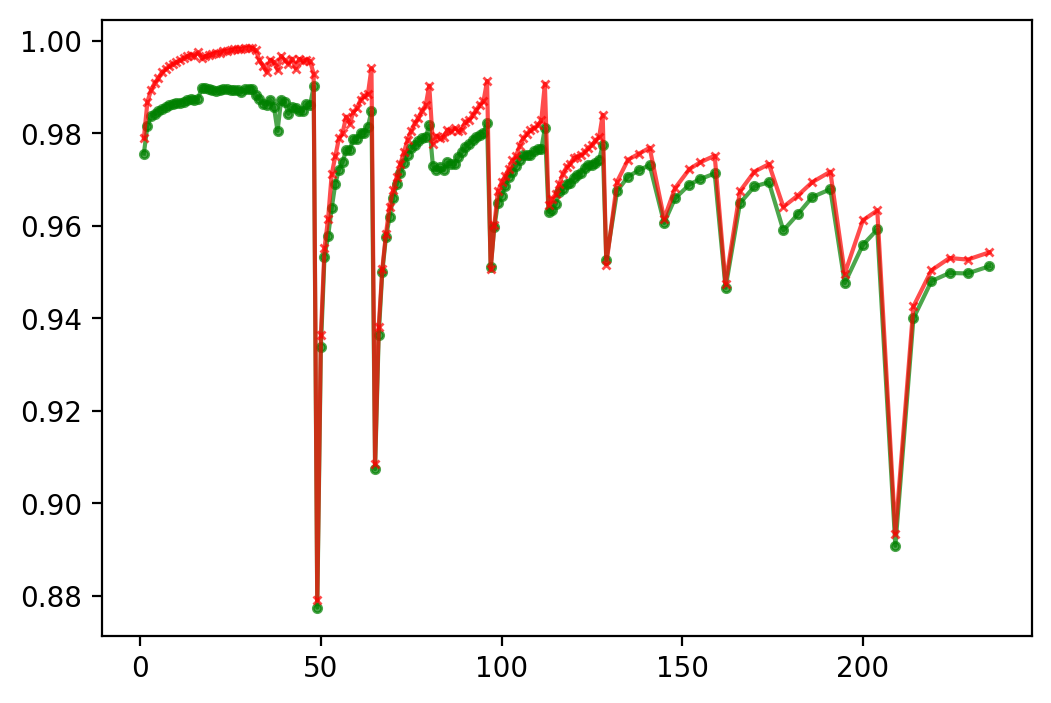

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(by_epoch['epoch'], by_epoch['test_accuracy_quantile_50'], '-og', markersize=3.0, alpha=.7)
plt.plot(by_epoch['epoch'], by_epoch['trained_accuracy_quantile_50'], '-xr', markersize=3.0, alpha=.7)


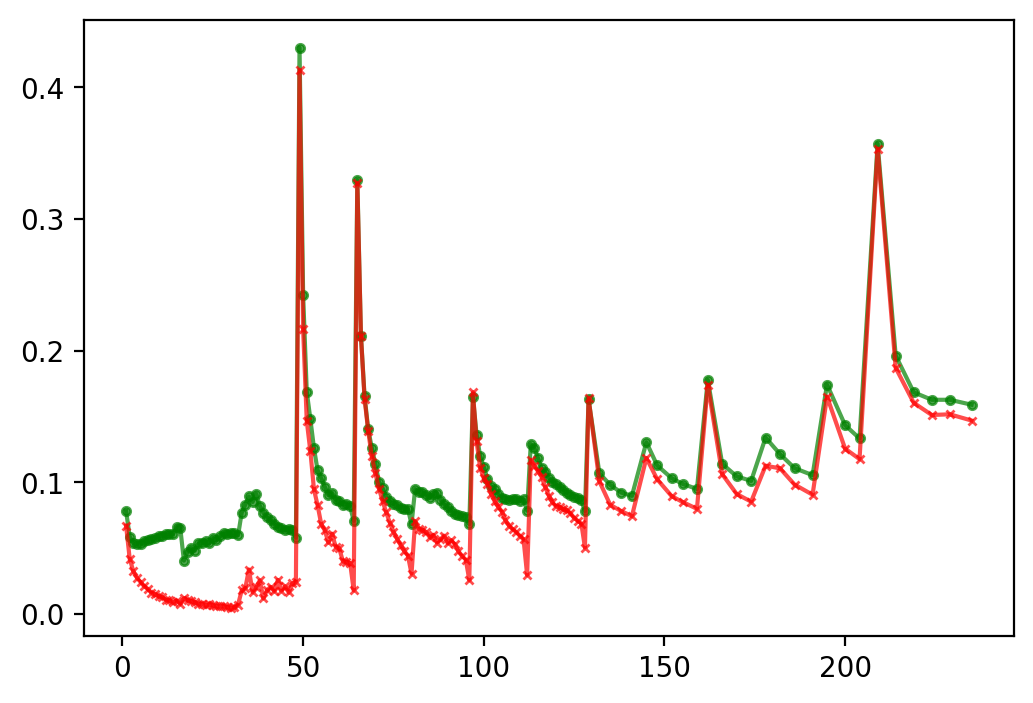

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))
plt.plot(by_epoch['epoch'], by_epoch['test_loss_quantile_50'], '-og', markersize=3.0, alpha=.7)
plt.plot(by_epoch['epoch'], by_epoch['trained_loss_quantile_50'], '-xr', markersize=3.0, alpha=.7)

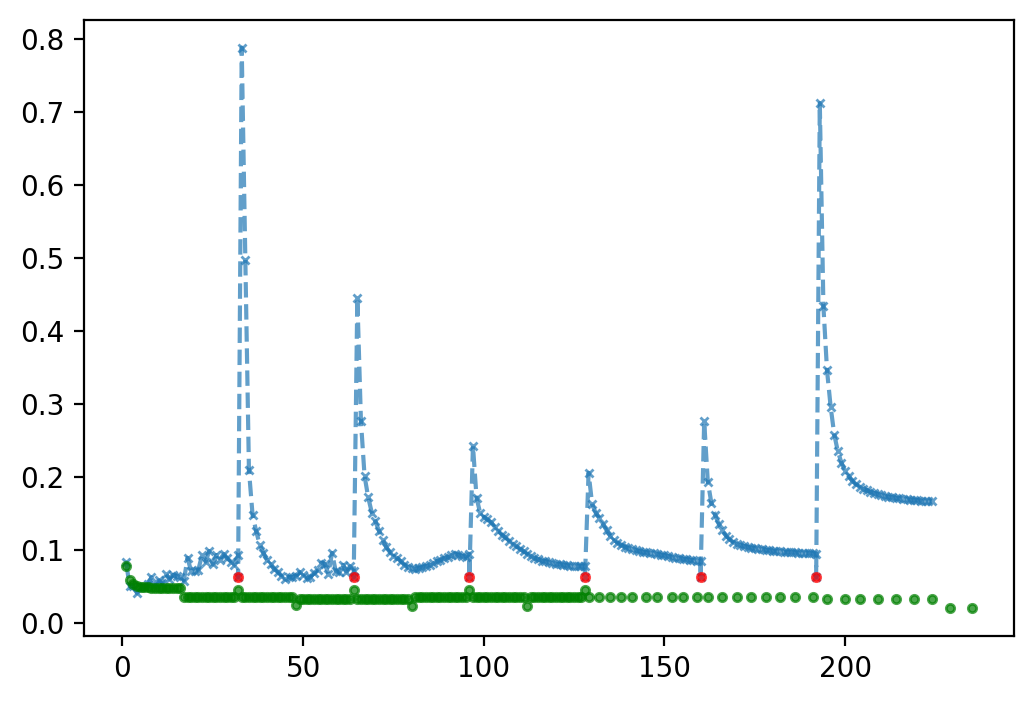

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['test_loss'], '--x', markersize=3.0, alpha=.7)
new_iterations = history[history['model_epoch'] == 0]
plt.plot(by_epoch['epoch'], by_epoch['test_loss_cmin_quantile_50'], 'og', markersize=3.0, alpha=.7)

plt.plot(new_iterations['epoch'], new_iterations['test_loss'], 'or', markersize=3.0, alpha=.7)


In [ ]:
history.columns

Index(['test_loss', 'trained_categorical_crossentropy', 'trained_accuracy',
       'train_categorical_crossentropy', 'free_parameter_count',
       'train_accuracy', 'retained', 'validation_categorical_crossentropy',
       'masked_parameter_count', 'validation_accuracy', 'trainms_ms',
       'trained_ms', 'train_loss', 'test_ms', 'model_epoch', 'epoch',
       'validation_loss', 'seed_number', 'test_accuracy', 'model_number',
       'test_categorical_crossentropy', 'trained_loss', 'epoch_startms_ms'],
      dtype='object')

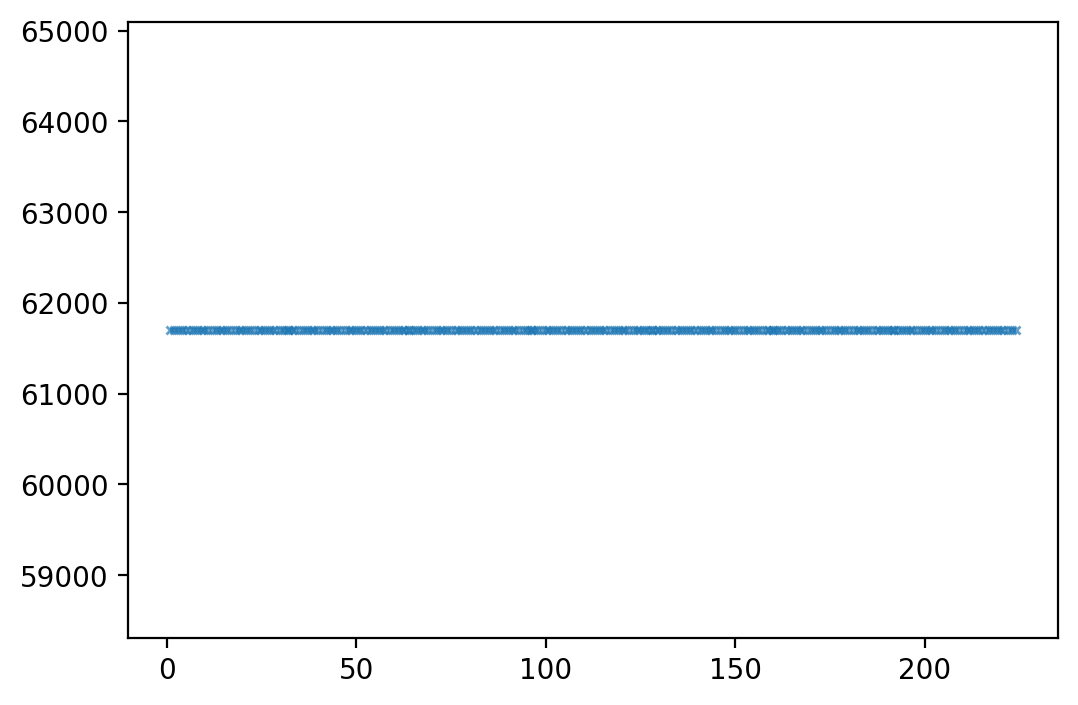

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['free_parameter_count'], '--x', markersize=3.0, alpha=.7)


In [ ]:

credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    by_epoch
FROM
    experiment2 e
WHERE TRUE
    AND e.experiment_id = 'b0d415cf-f228-c439-0480-3337c543c2e4'
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[0]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


by_epoch.describe()
by_epoch

,epoch,count,model_epoch_quantile_0,model_epoch_quantile_25,model_epoch_quantile_50,model_epoch_quantile_75,model_epoch_quantile_100,trained_categorical_crossentropy_quantile_0,trained_categorical_crossentropy_quantile_25,trained_categorical_crossentropy_quantile_50,...,test_accuracy_cmax_quantile_0,test_accuracy_cmax_quantile_25,test_accuracy_cmax_quantile_50,test_accuracy_cmax_quantile_75,test_accuracy_cmax_quantile_100,validation_accuracy_cmax_quantile_0,validation_accuracy_cmax_quantile_25,validation_accuracy_cmax_quantile_50,validation_accuracy_cmax_quantile_75,validation_accuracy_cmax_quantile_100
0,1,8,1.0,1.0,1.0,1.0,1.0,0.060437,0.061399,0.066523,...,0.9734,0.973925,0.97625,0.977575,0.9798,0.974000,0.975571,0.976571,0.977286,0.980571
1,2,8,2.0,2.0,2.0,2.0,2.0,0.039023,0.039946,0.041580,...,0.9762,0.980350,0.98225,0.982875,0.9843,0.980000,0.981071,0.981429,0.982143,0.985143
2,3,8,3.0,3.0,3.0,3.0,3.0,0.028624,0.030501,0.035552,...,0.9810,0.981500,0.98280,0.983900,0.9866,0.980857,0.981643,0.983000,0.984071,0.989429
3,4,8,4.0,4.0,4.0,4.0,4.0,0.019772,0.025258,0.027370,...,0.9812,0.981675,0.98450,0.985625,0.9885,0.980857,0.983214,0.983857,0.986857,0.989429
4,5,8,5.0,5.0,5.0,5.0,5.0,0.017522,0.022112,0.024034,...,0.9816,0.984450,0.98495,0.985650,0.9885,0.980857,0.983929,0.985429,0.987071,0.989429
5,6,8,6.0,6.0,6.0,6.0,6.0,0.016902,0.019114,0.019577,...,0.9819,0.984825,0.98520,0.986550,0.9885,0.984000,0.984786,0.985571,0.987071,0.989429
6,7,8,7.0,7.0,7.0,7.0,7.0,0.014243,0.016146,0.017878,...,0.9851,0.985725,0.98655,0.988050,0.9885,0.984000,0.985143,0.986000,0.987214,0.989429
7,8,8,8.0,8.0,8.0,8.0,8.0,0.010488,0.012256,0.017983,...,0.9851,0.986250,0.98745,0.988500,0.9888,0.984000,0.985143,0.986143,0.987214,0.989714
8,9,8,9.0,9.0,9.0,9.0,9.0,0.010544,0.011973,0.016272,...,0.9851,0.986250,0.98775,0.988500,0.9891,0.984000,0.985143,0.986143,0.987214,0.990000
9,10,8,10.0,10.0,10.0,10.0,10.0,0.008422,0.011188,0.012371,...,0.9859,0.986800,0.98775,0.988500,0.9897,0.984000,0.985143,0.986714,0.988643,0.990000


In [ ]:
df.columns

Index(['experiment_id', 'old_experiment_id', 'experiment_attrs', 'run_id',
       'job_id', 'slurm_job_id', 'run_timestamp', 'seed', 'task_version',
       'num_nodes',
       ...
       'precision', 'worker_id', 'record_model', 'record_times',
       'python_version', 'record_metrics', 'tensorflow_version',
       'tensorflow_strategy', 'record_post_training_metrics',
       'make_batch_optimizer_butter_growth_eagle_gpu_1'],
      dtype='object', length=105)

In [ ]:
df['run_history'].iloc[0]['train_loss']


0      1.247540
1      0.898057
2      0.847315
3      0.850349
4      0.847144
         ...   
145    0.225552
146    0.213775
147    0.213580
148    0.213284
149    0.210847
Name: train_loss, Length: 150, dtype: float32

In [ ]:
run_df = df['run_history'].iloc[0]
run_df['trained_loss'] - run_df['train_loss']

0      0.000000
1     -0.047707
2      0.003034
3      0.000000
4     -0.001494
         ...   
145    0.026551
146   -0.015600
147   -0.015426
148   -0.008199
149    0.011152
Length: 150, dtype: float32